In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d, median_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
import os

## GPR on different data quality

In [2]:
def f_loglin(x, x_c=1):
    return np.where(x < x_c, (x-x_c)/x_c+np.log(x_c), np.log(x))
def f_loglin_inv(y, y_c=0):
    return np.where(y < y_c, (1+y-y_c)*np.exp(y_c), np.exp(y))
def f_loglin_deriv(x, x_c=1):
    return np.where(x < x_c, 1/x_c, 1/x)

def f_mse(y, y_gt):
    return np.mean((y-y_gt)**2)/np.mean((y_gt)**2)

def desmear(Q,IQ,IQ_er,sigma_Q,n=3,sigmascale=1):
    I_ex = IQ
    I_ex_pos = I_ex[2*n:]
    I_ex_neg = I_ex[:-2*n]
    I_ex = I_ex[n:-n]
    sigma_Q_c = sigma_Q[n:-n]/sigmascale
    # sigma_Q_c = Q[n:-n]

    DQ = Q[n:] - Q[:-n]
    DQ_pos = DQ[n:]
    DQ_neg = DQ[:-n]

    I_ex2 = 2*(DQ_neg*I_ex_pos + DQ_pos*I_ex_neg - I_ex*(DQ_pos+DQ_neg))/(DQ_pos*DQ_neg*(DQ_pos+DQ_neg))
    I_des = I_ex - sigma_Q_c**2/2*I_ex2
    Q_des = Q[n:-n]

    # DI_ex = IQ_er
    # DI_ex[DI_ex==0] = np.min(DI_ex[DI_ex>0])
    # DI_ex_pos = DI_ex[2*n:]
    # DI_ex_neg = DI_ex[:-2*n]
    # DI_ex = DI_ex[n:-n]

    # DI_ex2_Sq = 4*((DQ_neg*DI_ex_pos)**2 + (DQ_pos*DI_ex_neg)**2 + ((DQ_neg+DQ_pos)*DI_ex)**2)/(DQ_pos*DQ_neg*(DQ_pos+DQ_neg))
    # DI_des = DI_ex*(1+sigma_Q_c**4/4*DI_ex2_Sq/DI_ex**2)
    
    return I_des

def f_log_likelihood(y, y_err, x, x_err, z_list = np.linspace(0, 0, 1), importance = None, index = None):
    """
    likelihood of y in the distribution of x
    """
    ## average over the ovservation uncertainty   
    log_likelihood = 0   
    sum_weight = 0  
    
    if importance is None:
        importance = np.ones(len(y))
    if index is None:
        index = np.arange(len(y))
    
    for z in z_list:
        weight_z = np.exp(-z**2/2)/np.sqrt(2*np.pi)
        y_z = y + y_err*z
        log_likelihood_z = -0.5 * np.sum((((y_z - x)**2 / x_err**2 + np.log(2 * np.pi * x_err**2))*importance)[index])
        log_likelihood += log_likelihood_z*weight_z
        sum_weight += weight_z
    log_likelihood = log_likelihood/sum_weight
    return log_likelihood



## EQSANS-SDS

In [3]:
# Define the folder path
folder_path = './data/EQSANS/SDS/'

# List all files in the folder
filenames = os.listdir(folder_path)

# Extract unique time values from filenames and sort them
time_values_from_filenames = np.unique([float(filename.split('_')[6]) for filename in filenames if filename.endswith('.dat')])
time_list = np.sort(time_values_from_filenames)

data_list = []

for i_time, time in enumerate(time_list):
    filename = f'SDS_5mgmL_20C_4m_fbt_0_{time:0.0f}_Iq.dat'
    data = np.loadtxt('./data/EQSANS/SDS/'+filename, skiprows=2)
    data_list.append(data)
    
    print(i_time, time_list[i_time])

0 1.0
1 2.0
2 3.0
3 4.0
4 5.0
5 6.0
6 7.0
7 8.0
8 9.0
9 10.0
10 15.0
11 20.0
12 25.0
13 30.0
14 60.0
15 90.0
16 120.0
17 240.0
18 360.0
19 480.0
20 600.0
21 720.0


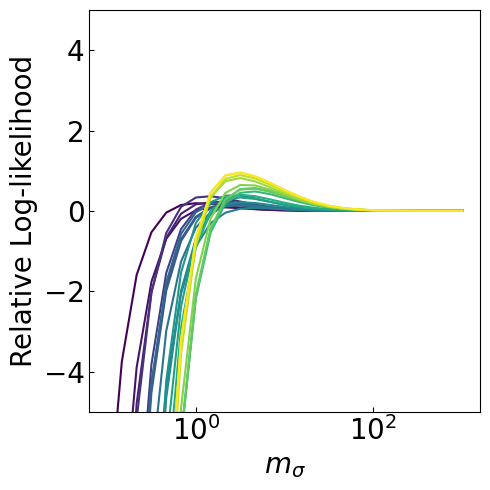

In [4]:
n_trial = 1
filter_size = 0.5
I_bg = 0.001
use_log_I = False
use_log_Q = True

# Transformations on Q and I(Q)
f_Q = lambda q: q
f_inv_Q = lambda fq: fq
if use_log_Q:
    f_Q = lambda q: np.log(q)
    f_inv_Q = lambda fq: np.exp(fq)


f_I = lambda I: I
f_inv_I = lambda fI: fI
# if use_log_I:
#     f_I = lambda I: np.log(I+I_bg)
#     f_inv_I = lambda fI: np.exp(fI)-I_bg
if use_log_I:
    f_I = lambda I: f_loglin(I, x_c=I_bg*2)
    f_inv_I = lambda fI: f_loglin_inv(fI, y_c=np.log(I_bg*2))

def get_viridis_color(value):
    cmap = plt.get_cmap('viridis')
    return cmap(value)

fig = plt.figure(figsize=(5, 5))

# n_sample_list = np.array([1000, 2000, 5000, 10000, 20000, 50000, 100000])
# n_sample_list = np.linspace(1000, 20000, 10)
n_sample_list = np.logspace(1, 7, 13)

list_L_gpr = []
list_L_exp = []
list_mse_gpr = []
list_mse_exp = []
list_G_acc_gpr = []
list_G_acc_exp = []
list_G_m = []

list_I_mean_gp = []
list_I_std_gp = []

for i_t, time in enumerate(time_list):
    
    ax = plt.subplot(1, 1, 1)

    color = get_viridis_color(i_t/(len(time_list)-1))


    log_likelihood_gt_exp = 0
    log_likelihood_gt_gpr = 0
    mse_exp = 0
    mse_gpr = 0
    G_acc_gpr = 0
    G_acc_exp = 0
    G_m = 0
    
    for i_trial in range(n_trial):
        # The noisy data
        index_data = i_t
        data = data_list[index_data]
        q_data = data[:, 0]
        I_data = data[:, 1]
        I_err_data = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
        # Scan through each data point, if find zero, assign that value as previous data
        for i in range(1, len(I_err_data)):
            if I_err_data[i] == 0:
                I_err_data[i] = I_err_data[i - 1]
                
        # The smooth data
        index_data_good = len(time_list)-1
        data = data_list[index_data_good]
        q_data_good = data[:, 0]
        I_data_good = data[:, 1]
        I_err_data_good = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
        # Scan through each data point, if find zero, assign that value as previous data
        for i in range(1, len(I_err_data_good)):
            if I_err_data_good[i] == 0:
                I_err_data_good[i] = I_err_data_good[i - 1]
                
        index_outlier_sm = (q_data > 0.4)|(q_data < 0.015)  
        index_outlier = (q_data < 0.4)&(q_data > 0.015)
        
        I_q_gf = np.zeros_like(q_data)
        for i_iterate in range(5):
            I_q_gf_i = np.zeros_like(q_data)
            I_iterate = I_data - I_q_gf
            for i in range(len(q_data)):
                weight_list = np.exp(-((f_Q(q_data[i])-f_Q(q_data))/filter_size)**2/2)
                weight_list[index_outlier_sm] = 0
                weight_list = weight_list/np.sum(weight_list)
                I_q_gf_i[i] = np.sum(I_iterate*weight_list)
            n_sm = 1
            I_q_gf_i[n_sm:-n_sm] = desmear(f_Q(q_data), I_q_gf_i, I_q_gf_i*0+1, np.ones_like(I_q_gf)*filter_size, n=n_sm, sigmascale=1)
            I_q_gf = I_q_gf + I_q_gf_i

        ## GPR
        sigma_list = np.logspace(-1, 3, 25)
        log_likelihood_list = []
        for sigma in sigma_list:
            lmbda = 0.225
            # sigma = 10

            ## define kernel function
            y_data = f_I(I_data)
            y_gt = f_I(I_data_good)
            y_bg = f_I(I_q_gf)
            # y_bg = y_gt
            y = y_data-y_bg

            # y_err = np.sqrt(n_sample/np.sum(n_pixels_q)*1/np.maximum(sum_q,np.ones_like(q)))
            y_err_pixel = I_err_data
            y_err = y_err_pixel
            if use_log_I:
                y_err = y_err_pixel*f_loglin_deriv(I_data, x_c=I_bg)

            # scale by a factor to check whether error estimation is correct
            m_factor = 1
            y_bg = y_bg*m_factor
            y_gt = y_gt*m_factor
            y = y*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))*np.random.normal(size = y.shape)
            y_err = y_err*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))
            y_data = y_data*m_factor
            sig_var = np.mean(y[index_outlier]**2)
            
            # fluctuations of the prior distribution
            prior_sigma = np.sqrt(sig_var)
            # prior_sigma = np.sqrt(np.mean(y_err**2))
            # prior_sigma = np.sqrt(y_err**2+sig_var) 

            q_x = q_data
            q_s = q_data

            def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
                if std_1 is None:
                    std_1 = np.ones_like(q1)
                if std_2 is None:
                    std_2 = np.ones_like(q2)
                K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
                return K
            
            f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
            K_sigma = np.diag(f_y_err(y_err))
            # K_sigma = sigma**2*np.eye(len(q_x))
            K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma #+ 0*np.eye(len(q_x))
            K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
            k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

            L = np.linalg.cholesky(K_xx)
            alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
            v = np.linalg.solve(L, K_xs)
            mu_s = K_xs.T @ alpha
            cov_s = k_ss - v.T @ v
            var_s = np.diag(cov_s)*prior_sigma**2
            std_s = np.sqrt(var_s)

            # evaluate the log likelihood
            log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
            log_likelihood_list.append(log_likelihood)
            
        log_likelihood_list = np.array(log_likelihood_list)
        log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q_s)

        ax.plot(sigma_list, log_likelihood_list, '-', color=color)
        ax.set_xscale('log')
        ax.set_ylim([-5, 5])
        ax.tick_params(direction='in', labelsize=20)
        ax.set_xlabel(r'$m_\sigma$', fontsize=20)
        ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

        sigma_best = sigma_list[np.argmax(log_likelihood_list)]
        
        # ax.legend(frameon=False, fontsize=13, ncol=2)
        plt.tight_layout()

        # GPR with best sigma
        f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
        K_sigma = np.diag(f_y_err(y_err))
        # K_sigma = sigma**2*np.eye(len(q_x))
        K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma
        K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
        k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

        L = np.linalg.cholesky(K_xx)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        v = np.linalg.solve(L, K_xs)
        mu_s = K_xs.T @ alpha
        cov_s = k_ss - v.T @ v
        var_s = np.diag(cov_s)*prior_sigma**2
        std_s = np.sqrt(var_s)
        
        I_mean_GP = f_inv_I(mu_s + y_bg)
        I_std_GP = std_s
        if use_log_I:
            I_std_GP = std_s/f_loglin_deriv(I_data, x_c=I_bg)
            
        delta_gp_bg = np.sqrt((f_inv_I(y_gt)-f_inv_I(y_bg))**2)
        # sigma_gt = np.ones_like(y_gt)*(np.max(y_gt)-np.min(y_gt))*1e-3
        sigma_gt = prior_sigma
        
        # Calculate the in terms of cross entropy      
        # h_gt_m = -f_log_likelihood((y_gt), sigma_gt, (y_bg), prior_sigma, z_list=np.linspace(-4, 4, 49))/len(q)#, z_list=np.linspace(-4, 4, 49))/len(q)#
        # h_gt_gpr = -f_log_likelihood((y_gt), sigma_gt, (mu_s + y_bg), std_s, z_list=np.linspace(-4, 4, 49))/len(q)#, z_list=np.linspace(-4, 4, 49))/len(q)#
        # h_gt_exp = -f_log_likelihood((y_gt), sigma_gt, (y_data), y_err, z_list=np.linspace(-4, 4, 49))/len(q)#, z_list=np.linspace(-4, 4, 49))/len(q)#
        
        importance = np.where((q_data > 0.014)&(q_data < 0.42), 1, 0)
        # importance = None
        
        h_m_gt = f_log_likelihood((y_bg), prior_sigma, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        h_gpr_gt = f_log_likelihood((mu_s + y_bg), std_s, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        h_exp_gt = f_log_likelihood((y_data), y_err, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        
        G_acc_gpr += h_gpr_gt#-h_m_gt
        G_acc_exp += h_exp_gt#-h_m_gt
        G_m += h_m_gt
        
        # likelihood of gt within the experimental prediction
        # log_likelihood_gt_exp += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), f_inv_I(y_data), y_err_pixel)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_exp += f_log_likelihood((y_gt), sigma_gt, y_data, y_err_pixel)/len(q_data)#, z_list=np.linspace(-4, 4, 49))
        
        # likelihood of gt within the GPR prediction
        # log_likelihood_gt_gpr += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), I_mean_GP, I_std_GP)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_gpr += f_log_likelihood((y_gt), sigma_gt, mu_s + y_bg, std_s)/len(q_data)#, z_list=np.linspace(-4, 4, 49))
        
        # mean squared error of gt and experimental prediction
        # mse_exp += f_mse(y + y_bg, y_gt)
        mse_exp += f_mse(f_inv_I(y_data),f_inv_I(y_gt))
        
        # mean squared error of gt and GPR prediction
        # mse_gpr += f_mse(mu_s + y_bg, y_gt)
        mse_gpr += f_mse(I_mean_GP, f_inv_I(y_gt))
        
    list_L_exp.append(log_likelihood_gt_exp/n_trial)
    list_L_gpr.append(log_likelihood_gt_gpr/n_trial)
    list_mse_exp.append(mse_exp/n_trial)
    list_mse_gpr.append(mse_gpr/n_trial)
    list_G_acc_gpr.append(G_acc_gpr/n_trial)
    list_G_acc_exp.append(G_acc_exp/n_trial)
    list_G_m.append(G_m/n_trial)
    
    list_I_mean_gp.append(I_mean_GP)
    list_I_std_gp.append(I_std_GP)

# convert the lists to numpy arrays
list_L_exp = np.array(list_L_exp)
list_L_gpr = np.array(list_L_gpr)
list_mse_exp = np.array(list_mse_exp)
list_mse_gpr = np.array(list_mse_gpr)
list_G_acc_gpr = np.array(list_G_acc_gpr)
list_G_acc_exp = np.array(list_G_acc_exp)
list_G_m = np.array(list_G_m)

/tmp/ipykernel_3252117/514749385.py:57: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "sr" (-> color='r'). The keyword argument will take precedence.
  ax.plot((list_G_acc_exp[-1]-list_G_acc_exp), time_list/time_gpr, 'sr', color='r', fillstyle='none', ms=8, markeredgewidth=2, label = r'$t_\mathrm{GPR}$')
/tmp/ipykernel_3252117/514749385.py:58: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  ax.plot([-0.5, 3], [1, 1], '--k', color='k', alpha=0.3, label = r'$t_\mathrm{Exp}$')


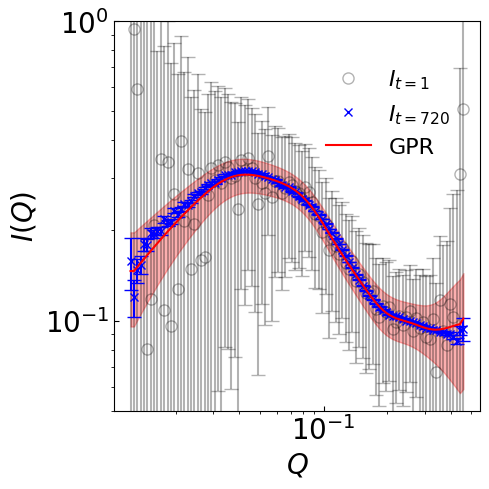

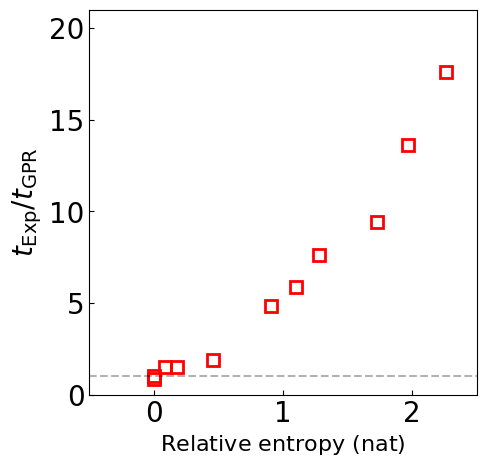

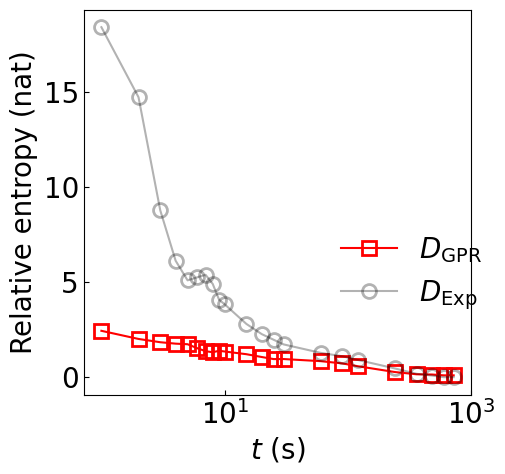

In [5]:
y_ref = y_gt
    
I_bg = f_inv_I(y_bg)

I_ref_plot = I_data_good

# plot the GPR result
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)

I_gp = list_I_mean_gp[0]
I_gp_err = list_I_std_gp[0]

data = data_list[0]
q_data = data[:, 0]
I_exp = data[:, 1]
I_exp_err = data[:, 2]

ax.plot(q_data, I_exp, 'ok', markersize=8, fillstyle='none', label=r'$I_{t=1}$', alpha=0.3) 
ax.errorbar(q_data, I_exp, yerr=I_exp_err, fmt='none', ecolor='k', capsize=5, alpha=0.3)

ax.fill_between(q_s, I_gp - I_gp_err, I_gp + I_gp_err, color='r', alpha=0.3)



# ax.plot(q_data, I_data_med , 'sc', label=r'$I_{t=240}$', fillstyle='none')
# ax.errorbar(q_data, I_data_med, yerr=I_err_data_med, fmt='none', ecolor='c', capsize=5)

ax.plot(q_data, I_data_good , 'xb', label=r'$I_{t=720}$')
ax.errorbar(q_data, I_data_good, yerr=I_err_data_good, fmt='none', ecolor='b', capsize=5)

# ax.plot(q_data, I_q_gf, '-g', label='BG')
ax.plot(q_s, I_gp, '-r', label='GPR')

ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)$', fontsize=20)

ax.tick_params(direction='in', labelsize=20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([0.05, 1])
# ax.set_ylim([0, 5])

ax.legend(frameon=False, fontsize=16, loc='lower center', bbox_to_anchor=(0.75, 0.6))
plt.tight_layout()

# plot the time required for the GPR and the experimental data to reach the same relative entropy
f_interp_gpr = interp1d(list_G_acc_gpr[-1]-list_G_acc_gpr, np.log(time_list), kind='linear', fill_value='extrapolate')

time_gpr = np.zeros_like(time_list)
for i in range(len(list_G_acc_exp)):
    H_exp_gt_i = list_G_acc_exp[-1]-list_G_acc_exp[i]
    time_gpr[i] = np.exp(f_interp_gpr(H_exp_gt_i))

fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)
ax.plot((list_G_acc_exp[-1]-list_G_acc_exp), time_list/time_gpr, 'sr', color='r', fillstyle='none', ms=8, markeredgewidth=2, label = r'$t_\mathrm{GPR}$')
ax.plot([-0.5, 3], [1, 1], '--k', color='k', alpha=0.3, label = r'$t_\mathrm{Exp}$')

ax.set_xticks([0,1,2])
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim([-0.5, 2.5])
ax.set_ylim([0, 21])
ax.tick_params(direction='in', labelsize=20)
# ax.tick_params(axis='x', direction='in', labelsize=18)
ax.set_xlabel(r'$\mathrm{Relative\ entropy} \ \mathrm{(nat)}}$', fontsize=16)
ax.set_ylabel(r'$t_\mathrm{Exp}/t_\mathrm{GPR}$', fontsize=20)
# ax.legend(frameon=False, fontsize=14, loc = 'upper left')

fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)
ax.plot(time_list, list_G_acc_exp[-1]-list_G_acc_gpr, '-s', color='r', label=r'$D_{\mathrm{GPR}}$', fillstyle='none', ms=10, markeredgewidth=2)
ax.plot(time_list, list_G_acc_exp[-1]-list_G_acc_exp, '-o', color='k', label=r'$D_{\mathrm{Exp}}$', alpha=0.3, fillstyle='none', ms=10, markeredgewidth=2)
# ax.plot(time_list, list_G_acc_exp[-1]-list_G_m, '-o', color='C2', label=r'$\left\langle D(p_{\mathrm{GT}}||p_{\mathrm{Ref}})\right\rangle_{Q}$')

ax.set_xticks(time_list)
ax.set_xscale('log')
# ax.set_xscale('log')
# ax.set_ylim([-1, 15])
ax.tick_params(direction='in', labelsize=20)
# ax.tick_params(axis='x', direction='in', labelsize=18)
ax.set_xlabel(r'$t \ (\mathrm{s})$', fontsize=20)
ax.set_ylabel(r'Relative entropy (nat)', fontsize=20)
ax.legend(frameon=False, fontsize=20, bbox_to_anchor=[0.6, 0.15, 0, 0])

filename = 'dKL_exp_SDS.dat'
np.savetxt(filename, np.c_[time_list, list_G_acc_gpr, list_G_acc_exp, list_G_m], header='time/counts D_GPR D_Exp D_Ref')

## EQSANS-21217

### HS 8m8a

In [6]:
# Define the folder path
folder_path = './data/EQSANS/output_21217/'

# List all files in the folder
filenames = os.listdir(folder_path)

# Extract unique time values from filenames and sort them
time_values_from_filenames = np.unique([float(filename.split('_')[5]) for filename in filenames if filename.endswith('.dat') and '8m8a' in filename and 'HS' in filename])
time_list = np.sort(time_values_from_filenames)

data_list = []

for i_time, time in enumerate(time_list):
    filename = f'HS-100_10C_8m8a_time_0_{time:0.0f}_Iq.dat'
    data = np.loadtxt(folder_path+filename, skiprows=2)
    data_list.append(data)
    
    print(i_time, time_list[i_time])

0 120.0
1 240.0
2 360.0
3 480.0
4 600.0
5 720.0
6 840.0
7 960.0
8 1080.0
9 1200.0
10 1320.0
11 1440.0
12 1560.0
13 1680.0
14 1800.0
15 1920.0
16 2040.0
17 2160.0
18 2280.0
19 2400.0
20 2520.0
21 2640.0
22 2760.0
23 2880.0
24 3000.0
25 3120.0
26 3240.0
27 3360.0
28 3480.0
29 3600.0
30 3720.0
31 3840.0
32 3960.0
33 4080.0
34 4200.0
35 4320.0
36 4440.0
37 4560.0
38 4680.0
39 4800.0
40 4920.0
41 5040.0
42 5160.0
43 5280.0
44 5400.0
45 5520.0
46 5640.0
47 5760.0
48 5880.0
49 6000.0
50 6120.0
51 6240.0
52 6360.0
53 6480.0
54 6600.0
55 6720.0
56 6840.0
57 6960.0
58 7080.0
59 7200.0


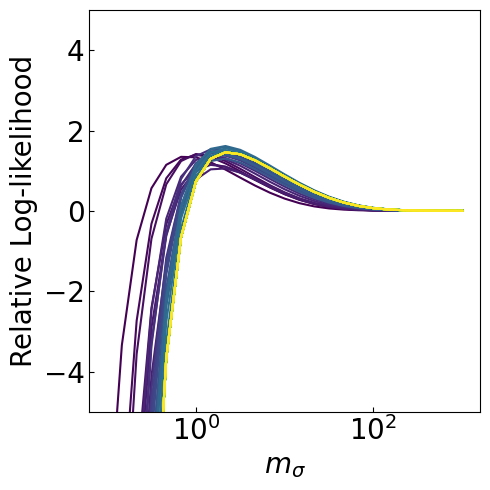

In [7]:
n_trial = 1
filter_size = 0.25
I_bg = 0.1
use_log_I = False
use_log_Q = True

# Transformations on Q and I(Q)
f_Q = lambda q: q
f_inv_Q = lambda fq: fq
if use_log_Q:
    f_Q = lambda q: np.log(q)
    f_inv_Q = lambda fq: np.exp(fq)


f_I = lambda I: I
f_inv_I = lambda fI: fI
# if use_log_I:
#     f_I = lambda I: np.log(I+I_bg)
#     f_inv_I = lambda fI: np.exp(fI)-I_bg
if use_log_I:
    f_I = lambda I: f_loglin(I, x_c=I_bg*2)
    f_inv_I = lambda fI: f_loglin_inv(fI, y_c=np.log(I_bg*2))

def get_viridis_color(value):
    cmap = plt.get_cmap('viridis')
    return cmap(value)

fig = plt.figure(figsize=(5, 5))

# n_sample_list = np.array([1000, 2000, 5000, 10000, 20000, 50000, 100000])
# n_sample_list = np.linspace(1000, 20000, 10)
n_sample_list = np.logspace(1, 7, 13)

list_L_gpr = []
list_L_exp = []
list_mse_gpr = []
list_mse_exp = []
list_G_acc_gpr = []
list_G_acc_exp = []
list_G_m = []

list_I_mean_gp = []
list_I_std_gp = []

for i_t, time in enumerate(time_list):
    
    ax = plt.subplot(1, 1, 1)

    color = get_viridis_color(i_t/(len(time_list)-1))


    log_likelihood_gt_exp = 0
    log_likelihood_gt_gpr = 0
    mse_exp = 0
    mse_gpr = 0
    G_acc_gpr = 0
    G_acc_exp = 0
    G_m = 0
    
    for i_trial in range(n_trial):
        # The noisy data
        index_data = i_t
        data = data_list[index_data]
        q_data = data[:, 0]
        I_data = data[:, 1]
        I_err_data = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
        # Scan through each data point, if find zero, assign that value as previous data
        for i in range(1, len(I_err_data)):
            if I_err_data[i] == 0:
                I_err_data[i] = I_err_data[i - 1]
                
        # The smooth data
        index_data_good = len(time_list)-1
        data = data_list[index_data_good]
        q_data_good = data[:, 0]
        I_data_good = data[:, 1]
        I_err_data_good = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
        # Scan through each data point, if find zero, assign that value as previous data
        for i in range(1, len(I_err_data_good)):
            if I_err_data_good[i] == 0:
                I_err_data_good[i] = I_err_data_good[i - 1]
                
        index_outlier_sm = (q_data > 0.07)|(q_data < 0.0031)  
        index_outlier = (q_data < 0.07)&(q_data > 0.0031)
        
        I_q_gf = np.zeros_like(q_data)
        for i_iterate in range(5):
            I_q_gf_i = np.zeros_like(q_data)
            I_iterate = I_data - I_q_gf
            for i in range(len(q_data)):
                weight_list = np.exp(-((f_Q(q_data[i])-f_Q(q_data))/filter_size)**2/2)
                weight_list[index_outlier_sm] = 0
                weight_list = weight_list/np.sum(weight_list)
                I_q_gf_i[i] = np.sum(I_iterate*weight_list)
            n_sm = 1
            I_q_gf_i[n_sm:-n_sm] = desmear(f_Q(q_data), I_q_gf_i, I_q_gf_i*0+1, np.ones_like(I_q_gf)*filter_size, n=n_sm, sigmascale=1)
            I_q_gf = I_q_gf + I_q_gf_i

        ## GPR
        sigma_list = np.logspace(-1, 3, 25)
        log_likelihood_list = []
        for sigma in sigma_list:
            lmbda = 0.18
            # sigma = 10

            ## define kernel function
            y_data = f_I(I_data)
            y_gt = f_I(I_data_good)
            y_bg = f_I(I_q_gf)
            # y_bg = y_gt
            y = y_data-y_bg

            # y_err = np.sqrt(n_sample/np.sum(n_pixels_q)*1/np.maximum(sum_q,np.ones_like(q)))
            y_err_pixel = I_err_data
            y_err = y_err_pixel
            if use_log_I:
                y_err = y_err_pixel*f_loglin_deriv(I_data, x_c=I_bg*2)

            # scale by a factor to check whether error estimation is correct
            m_factor = 1
            y_bg = y_bg*m_factor
            y_gt = y_gt*m_factor
            y = y*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))*np.random.normal(size = y.shape)
            y_err = y_err*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))
            y_data = y_data*m_factor
            sig_var = np.mean(y[index_outlier]**2)
            
            # # exclude outliers
            # y_bg = y_bg[index_outlier]
            # y_gt = y_gt[index_outlier]
            # y = y[index_outlier]
            # y_err = y_err[index_outlier]
            # y_data = y_data[index_outlier]
            # q_data = q_data[index_outlier]

            # fluctuations of the prior distribution
            prior_sigma = np.sqrt(sig_var)
            # prior_sigma = np.sqrt(np.mean(y_err**2))
            # prior_sigma = np.sqrt(y_err**2+sig_var) 

            q_x = q_data
            q_s = q_data

            def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
                if std_1 is None:
                    std_1 = np.ones_like(q1)
                if std_2 is None:
                    std_2 = np.ones_like(q2)
                K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
                return K
            
            f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
            K_sigma = np.diag(f_y_err(y_err))
            # K_sigma = sigma**2*np.eye(len(q_x))
            K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma #+ 0*np.eye(len(q_x))
            K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
            k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

            L = np.linalg.cholesky(K_xx)
            alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
            v = np.linalg.solve(L, K_xs)
            mu_s = K_xs.T @ alpha
            cov_s = k_ss - v.T @ v
            var_s = np.diag(cov_s)*prior_sigma**2
            std_s = np.sqrt(var_s)

            # evaluate the log likelihood
            log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
            log_likelihood_list.append(log_likelihood)
            
        log_likelihood_list = np.array(log_likelihood_list)
        log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q_s)

        ax.plot(sigma_list, log_likelihood_list, '-', color=color)
        ax.set_xscale('log')
        ax.set_ylim([-5, 5])
        ax.tick_params(direction='in', labelsize=20)
        ax.set_xlabel(r'$m_\sigma$', fontsize=20)
        ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

        sigma_best = sigma_list[np.argmax(log_likelihood_list)]
        
        # ax.legend(frameon=False, fontsize=13, ncol=2)
        plt.tight_layout()

        # GPR with best sigma
        f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
        K_sigma = np.diag(f_y_err(y_err))
        # K_sigma = sigma**2*np.eye(len(q_x))
        K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma
        K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
        k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

        L = np.linalg.cholesky(K_xx)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        v = np.linalg.solve(L, K_xs)
        mu_s = K_xs.T @ alpha
        cov_s = k_ss - v.T @ v
        var_s = np.diag(cov_s)*prior_sigma**2
        std_s = np.sqrt(var_s)
        
        I_mean_GP = f_inv_I(mu_s + y_bg)
        I_std_GP = std_s
        if use_log_I:
            I_std_GP = std_s/f_loglin_deriv(I_data, x_c=I_bg*2)
            
        delta_gp_bg = np.sqrt((f_inv_I(y_gt)-f_inv_I(y_bg))**2)
        # sigma_gt = np.ones_like(y_gt)*(np.max(y_gt)-np.min(y_gt))*1e-3
        sigma_gt = prior_sigma
        
        # Calculate the in terms of cross entropy              
        importance = np.where((q_data > 0.07)|(q_data < 0.0031) , 0, 1)
        # importance = None
        
        h_m_gt = f_log_likelihood((y_bg), prior_sigma, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        h_gpr_gt = f_log_likelihood((mu_s + y_bg), std_s, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        h_exp_gt = f_log_likelihood((y_data), y_err, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)

        
        G_acc_gpr += h_gpr_gt#-h_m_gt
        G_acc_exp += h_exp_gt#-h_m_gt
        G_m += h_m_gt
        
        # likelihood of gt within the experimental prediction
        # log_likelihood_gt_exp += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), f_inv_I(y_data), y_err_pixel)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_exp += f_log_likelihood((y_gt), sigma_gt, y_data, y_err_pixel)/len(q_data)#, z_list=np.linspace(-4, 4, 49))
        
        # likelihood of gt within the GPR prediction
        # log_likelihood_gt_gpr += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), I_mean_GP, I_std_GP)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_gpr += f_log_likelihood((y_gt), sigma_gt, mu_s + y_bg, std_s)/len(q_data)#, z_list=np.linspace(-4, 4, 49))
        
        # mean squared error of gt and experimental prediction
        # mse_exp += f_mse(y + y_bg, y_gt)
        mse_exp += f_mse(f_inv_I(y_data),f_inv_I(y_gt))
        
        # mean squared error of gt and GPR prediction
        # mse_gpr += f_mse(mu_s + y_bg, y_gt)
        mse_gpr += f_mse(I_mean_GP, f_inv_I(y_gt))
        
    list_I_mean_gp.append(I_mean_GP)
    list_I_std_gp.append(I_std_GP)        
        
    list_L_exp.append(log_likelihood_gt_exp/n_trial)
    list_L_gpr.append(log_likelihood_gt_gpr/n_trial)
    list_mse_exp.append(mse_exp/n_trial)
    list_mse_gpr.append(mse_gpr/n_trial)
    list_G_acc_gpr.append(G_acc_gpr/n_trial)
    list_G_acc_exp.append(G_acc_exp/n_trial)
    list_G_m.append(G_m/n_trial)

# convert the lists to numpy arrays
list_L_exp = np.array(list_L_exp)
list_L_gpr = np.array(list_L_gpr)
list_mse_exp = np.array(list_mse_exp)
list_mse_gpr = np.array(list_mse_gpr)
list_G_acc_gpr = np.array(list_G_acc_gpr)
list_G_acc_exp = np.array(list_G_acc_exp)
list_G_m = np.array(list_G_m)

/tmp/ipykernel_3252117/169303645.py:58: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "sr" (-> color='r'). The keyword argument will take precedence.
  ax.plot((list_G_acc_exp[-1]-list_G_acc_exp), time_list/time_gpr, 'sr', color='r', fillstyle='none', ms=8, markeredgewidth=2, label = r'$t_\mathrm{GPR}$')
/tmp/ipykernel_3252117/169303645.py:59: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  ax.plot([-0.5, 3], [1, 1], '--k', color='k', alpha=0.3, label = r'$t_\mathrm{Exp}$')


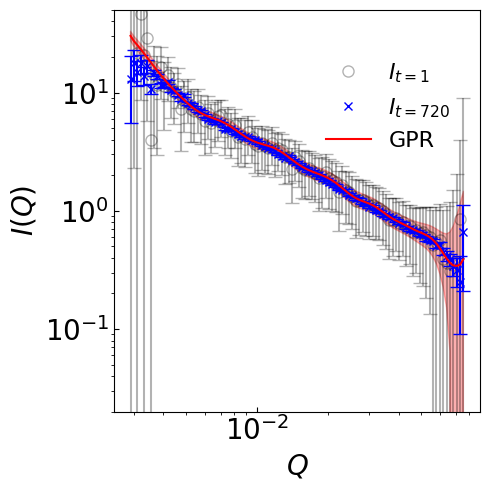

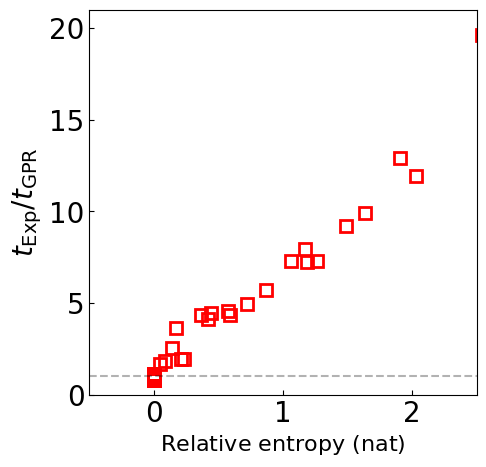

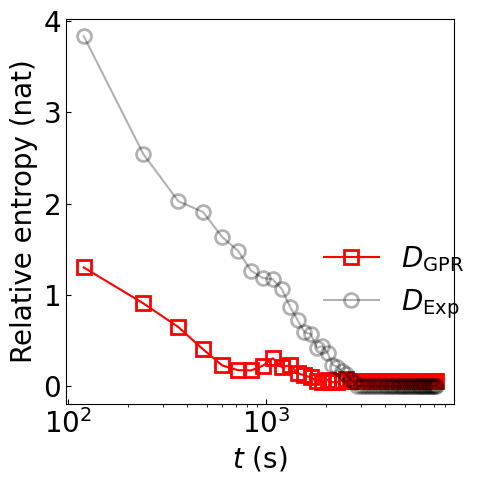

In [8]:
y_ref = y_gt
    
I_bg = f_inv_I(y_bg)

I_ref_plot = I_data_good

# plot the GPR result
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)

i_time_exp = 0
I_gp = list_I_mean_gp[i_time_exp]
I_gp_err = list_I_std_gp[i_time_exp]

data = data_list[i_time_exp]
q_data = data[:, 0]
I_exp = data[:, 1]
I_exp_err = data[:, 2]

ax.plot(q_data, I_exp, 'ok', markersize=8, fillstyle='none', label=r'$I_{t=1}$', alpha=0.3) 
ax.errorbar(q_data, I_exp, yerr=I_exp_err, fmt='none', ecolor='k', capsize=5, alpha=0.3)

ax.fill_between(q_s, I_gp - I_gp_err, I_gp + I_gp_err, color='r', alpha=0.3)



# ax.plot(q_data, I_data_med , 'sc', label=r'$I_{t=240}$', fillstyle='none')
# ax.errorbar(q_data, I_data_med, yerr=I_err_data_med, fmt='none', ecolor='c', capsize=5)

ax.plot(q_data, I_data_good , 'xb', label=r'$I_{t=720}$')
ax.errorbar(q_data, I_data_good, yerr=I_err_data_good, fmt='none', ecolor='b', capsize=5)

# ax.plot(q_data, I_q_gf, '-g', label='BG')
ax.plot(q_s, I_gp, '-r', label='GPR')

ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)$', fontsize=20)

ax.tick_params(direction='in', labelsize=20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([0.02, 50])
# ax.set_ylim([0, 5])

ax.legend(frameon=False, fontsize=16, loc='lower center', bbox_to_anchor=(0.75, 0.6))
plt.tight_layout()

# plot the time required for the GPR and the experimental data to reach the same relative entropy
f_interp_gpr = interp1d(list_G_acc_gpr[-1]-list_G_acc_gpr, np.log(time_list), kind='linear', fill_value='extrapolate')

time_gpr = np.zeros_like(time_list)
for i in range(len(list_G_acc_exp)):
    H_exp_gt_i = list_G_acc_exp[-1]-list_G_acc_exp[i]
    time_gpr[i] = np.exp(f_interp_gpr(H_exp_gt_i))

fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)
ax.plot((list_G_acc_exp[-1]-list_G_acc_exp), time_list/time_gpr, 'sr', color='r', fillstyle='none', ms=8, markeredgewidth=2, label = r'$t_\mathrm{GPR}$')
ax.plot([-0.5, 3], [1, 1], '--k', color='k', alpha=0.3, label = r'$t_\mathrm{Exp}$')

ax.set_xticks([0,1,2])
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim([-0.5, 2.5])
ax.set_ylim([0, 21])
ax.tick_params(direction='in', labelsize=20)
# ax.tick_params(axis='x', direction='in', labelsize=18)
ax.set_xlabel(r'$\mathrm{Relative\ entropy} \ \mathrm{(nat)}}$', fontsize=16)
ax.set_ylabel(r'$t_\mathrm{Exp}/t_\mathrm{GPR}$', fontsize=20)
# ax.legend(frameon=False, fontsize=14, loc = 'upper left')

filename = 'dKL_exp_21217-8m8a-HS.dat'
np.savetxt(filename, np.c_[time_list, list_G_acc_gpr, list_G_acc_exp, list_G_m], header='time/counts D_GPR D_Exp D_Ref')

fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)
ax.plot(time_list, list_G_acc_exp[-1]-list_G_acc_gpr, '-s', color='r', label=r'$D_{\mathrm{GPR}}$', fillstyle='none', ms=10, markeredgewidth=2)
ax.plot(time_list, list_G_acc_exp[-1]-list_G_acc_exp, '-o', color='k', label=r'$D_{\mathrm{Exp}}$', alpha=0.3, fillstyle='none', ms=10, markeredgewidth=2)
# ax.plot(time_list, list_G_acc_exp[-1]-list_G_m, '-o', color='C2', label=r'$\left\langle D(p_{\mathrm{GT}}||p_{\mathrm{Ref}})\right\rangle_{Q}$')

ax.set_xticks(time_list)
ax.set_xscale('log')
# ax.set_xscale('log')
# ax.set_ylim([-1, 15])
ax.tick_params(direction='in', labelsize=20)
# ax.tick_params(axis='x', direction='in', labelsize=18)
ax.set_xlabel(r'$t \ (\mathrm{s})$', fontsize=20)
ax.set_ylabel(r'Relative entropy (nat)', fontsize=20)
ax.legend(frameon=False, fontsize=20, bbox_to_anchor=[0.6, 0.15, 0, 0])

### HS 4m4a

In [9]:
# Define the folder path
folder_path = './data/EQSANS/output_21217/'

# List all files in the folder
filenames = os.listdir(folder_path)

# Extract unique time values from filenames and sort them
time_values_from_filenames = np.unique([float(filename.split('_')[5]) for filename in filenames if filename.endswith('.dat') and '4m4a' in filename and 'HS' in filename])
time_list = np.sort(time_values_from_filenames)

data_list = []

for i_time, time in enumerate(time_list):
    filename = f'HS-100_10C_4m4a_time_0_{time:0.0f}_Iq.dat'
    data = np.loadtxt(folder_path+filename, skiprows=2)
    data_list.append(data)
    
    print(i_time, time_list[i_time])

0 120.0
1 240.0
2 360.0
3 480.0
4 600.0
5 720.0
6 840.0
7 960.0
8 1080.0
9 1200.0
10 1320.0
11 1440.0
12 1560.0
13 1680.0
14 1800.0
15 1920.0
16 2040.0
17 2160.0
18 2280.0
19 2400.0
20 2520.0
21 2640.0
22 2760.0
23 2880.0
24 3000.0
25 3120.0
26 3240.0
27 3360.0
28 3480.0
29 3600.0
30 3720.0
31 3840.0
32 3960.0
33 4080.0
34 4200.0
35 4320.0
36 4440.0
37 4560.0
38 4680.0
39 4800.0
40 4920.0
41 5040.0
42 5160.0
43 5280.0
44 5400.0
45 5520.0
46 5640.0
47 5760.0
48 5880.0
49 6000.0
50 6120.0
51 6240.0
52 6360.0
53 6480.0
54 6600.0
55 6720.0
56 6840.0
57 6960.0
58 7080.0
59 7200.0


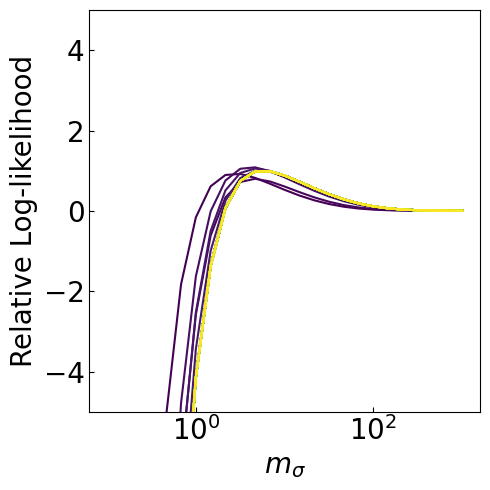

In [10]:
n_trial = 1
filter_size = 0.25
I_bg = 0.1
use_log_I = False
use_log_Q = True

# Transformations on Q and I(Q)
f_Q = lambda q: q
f_inv_Q = lambda fq: fq
if use_log_Q:
    f_Q = lambda q: np.log(q)
    f_inv_Q = lambda fq: np.exp(fq)


f_I = lambda I: I
f_inv_I = lambda fI: fI
# if use_log_I:
#     f_I = lambda I: np.log(I+I_bg)
#     f_inv_I = lambda fI: np.exp(fI)-I_bg
if use_log_I:
    f_I = lambda I: f_loglin(I, x_c=I_bg*2)
    f_inv_I = lambda fI: f_loglin_inv(fI, y_c=np.log(I_bg*2))

def get_viridis_color(value):
    cmap = plt.get_cmap('viridis')
    return cmap(value)

fig = plt.figure(figsize=(5, 5))

# n_sample_list = np.array([1000, 2000, 5000, 10000, 20000, 50000, 100000])
# n_sample_list = np.linspace(1000, 20000, 10)
n_sample_list = np.logspace(1, 7, 13)

list_L_gpr = []
list_L_exp = []
list_mse_gpr = []
list_mse_exp = []
list_G_acc_gpr = []
list_G_acc_exp = []
list_G_m = []

list_I_mean_gp = []
list_I_std_gp = []

for i_t, time in enumerate(time_list):
    
    ax = plt.subplot(1, 1, 1)

    color = get_viridis_color(i_t/(len(time_list)-1))


    log_likelihood_gt_exp = 0
    log_likelihood_gt_gpr = 0
    mse_exp = 0
    mse_gpr = 0
    G_acc_gpr = 0
    G_acc_exp = 0
    G_m = 0
    
    for i_trial in range(n_trial):
        # The noisy data
        index_data = i_t
        data = data_list[index_data]
        q_data = data[:, 0]
        I_data = data[:, 1]
        I_err_data = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
        # Scan through each data point, if find zero, assign that value as previous data
        for i in range(1, len(I_err_data)):
            if I_err_data[i] == 0:
                I_err_data[i] = I_err_data[i - 1]
                
        # The smooth data
        index_data_good = len(time_list)-1
        data = data_list[index_data_good]
        q_data_good = data[:, 0]
        I_data_good = data[:, 1]
        I_err_data_good = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
        # Scan through each data point, if find zero, assign that value as previous data
        for i in range(1, len(I_err_data_good)):
            if I_err_data_good[i] == 0:
                I_err_data_good[i] = I_err_data_good[i - 1]
                
        index_outlier_sm = (q_data > 0.3)|(q_data < 0.011)  
        index_outlier = (q_data < 0.3)&(q_data > 0.011)
        
        I_q_gf = np.zeros_like(q_data)
        for i_iterate in range(5):
            I_q_gf_i = np.zeros_like(q_data)
            I_iterate = I_data - I_q_gf
            for i in range(len(q_data)):
                weight_list = np.exp(-((f_Q(q_data[i])-f_Q(q_data))/filter_size)**2/2)
                weight_list[index_outlier_sm] = 0
                weight_list = weight_list/np.sum(weight_list)
                I_q_gf_i[i] = np.sum(I_iterate*weight_list)
            n_sm = 1
            I_q_gf_i[n_sm:-n_sm] = desmear(f_Q(q_data), I_q_gf_i, I_q_gf_i*0+1, np.ones_like(I_q_gf)*filter_size, n=n_sm, sigmascale=1)
            I_q_gf = I_q_gf + I_q_gf_i

        ## GPR
        sigma_list = np.logspace(-1, 3, 25)
        log_likelihood_list = []
        for sigma in sigma_list:
            lmbda = 0.18
            # sigma = 10

            ## define kernel function
            y_data = f_I(I_data)
            y_gt = f_I(I_data_good)
            y_bg = f_I(I_q_gf)
            # y_bg = y_gt
            y = y_data-y_bg

            # y_err = np.sqrt(n_sample/np.sum(n_pixels_q)*1/np.maximum(sum_q,np.ones_like(q)))
            y_err_pixel = I_err_data
            y_err = y_err_pixel
            if use_log_I:
                y_err = y_err_pixel*f_loglin_deriv(I_data, x_c=I_bg*2)

            # scale by a factor to check whether error estimation is correct
            m_factor = 1
            y_bg = y_bg*m_factor
            y_gt = y_gt*m_factor
            y = y*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))*np.random.normal(size = y.shape)
            y_err = y_err*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))
            y_data = y_data*m_factor
            sig_var = np.mean(y[index_outlier]**2)
            
            # fluctuations of the prior distribution
            prior_sigma = np.sqrt(sig_var)
            # prior_sigma = np.sqrt(np.mean(y_err**2))
            # prior_sigma = np.sqrt(y_err**2+sig_var) 

            q_x = q_data
            q_s = q_data

            def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
                if std_1 is None:
                    std_1 = np.ones_like(q1)
                if std_2 is None:
                    std_2 = np.ones_like(q2)
                K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
                return K
            
            f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
            K_sigma = np.diag(f_y_err(y_err))
            # K_sigma = sigma**2*np.eye(len(q_x))
            K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma #+ 0*np.eye(len(q_x))
            K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
            k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

            L = np.linalg.cholesky(K_xx)
            alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
            v = np.linalg.solve(L, K_xs)
            mu_s = K_xs.T @ alpha
            cov_s = k_ss - v.T @ v
            var_s = np.diag(cov_s)*prior_sigma**2
            std_s = np.sqrt(var_s)

            # evaluate the log likelihood
            log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
            log_likelihood_list.append(log_likelihood)
            
        log_likelihood_list = np.array(log_likelihood_list)
        log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q_s)

        ax.plot(sigma_list, log_likelihood_list, '-', color=color)
        ax.set_xscale('log')
        ax.set_ylim([-5, 5])
        ax.tick_params(direction='in', labelsize=20)
        ax.set_xlabel(r'$m_\sigma$', fontsize=20)
        ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

        sigma_best = sigma_list[np.argmax(log_likelihood_list)]
        
        # ax.legend(frameon=False, fontsize=13, ncol=2)
        plt.tight_layout()

        # GPR with best sigma
        f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
        K_sigma = np.diag(f_y_err(y_err))
        # K_sigma = sigma**2*np.eye(len(q_x))
        K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma
        K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
        k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

        L = np.linalg.cholesky(K_xx)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        v = np.linalg.solve(L, K_xs)
        mu_s = K_xs.T @ alpha
        cov_s = k_ss - v.T @ v
        var_s = np.diag(cov_s)*prior_sigma**2
        std_s = np.sqrt(var_s)
        
        I_mean_GP = f_inv_I(mu_s + y_bg)
        I_std_GP = std_s
        if use_log_I:
            I_std_GP = std_s/f_loglin_deriv(I_data, x_c=I_bg*2)
            
        delta_gp_bg = np.sqrt((f_inv_I(y_gt)-f_inv_I(y_bg))**2)
        # sigma_gt = np.ones_like(y_gt)*(np.max(y_gt)-np.min(y_gt))*1e-3
        sigma_gt = prior_sigma
        
        # Calculate the in terms of cross entropy              
        importance = np.where((q_data > 0.3)|(q_data < 0.011) , 0, 1)
        # importance = None
        
        h_m_gt = f_log_likelihood((y_bg), prior_sigma, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        h_gpr_gt = f_log_likelihood((mu_s + y_bg), std_s, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        h_exp_gt = f_log_likelihood((y_data), y_err, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)

        
        G_acc_gpr += h_gpr_gt#-h_m_gt
        G_acc_exp += h_exp_gt#-h_m_gt
        G_m += h_m_gt
        
        # likelihood of gt within the experimental prediction
        # log_likelihood_gt_exp += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), f_inv_I(y_data), y_err_pixel)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_exp += f_log_likelihood((y_gt), sigma_gt, y_data, y_err_pixel)/len(q_data)#, z_list=np.linspace(-4, 4, 49))
        
        # likelihood of gt within the GPR prediction
        # log_likelihood_gt_gpr += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), I_mean_GP, I_std_GP)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_gpr += f_log_likelihood((y_gt), sigma_gt, mu_s + y_bg, std_s)/len(q_data)#, z_list=np.linspace(-4, 4, 49))
        
        # mean squared error of gt and experimental prediction
        # mse_exp += f_mse(y + y_bg, y_gt)
        mse_exp += f_mse(f_inv_I(y_data),f_inv_I(y_gt))
        
        # mean squared error of gt and GPR prediction
        # mse_gpr += f_mse(mu_s + y_bg, y_gt)
        mse_gpr += f_mse(I_mean_GP, f_inv_I(y_gt))
        
    list_I_mean_gp.append(I_mean_GP)
    list_I_std_gp.append(I_std_GP)        
        
    list_L_exp.append(log_likelihood_gt_exp/n_trial)
    list_L_gpr.append(log_likelihood_gt_gpr/n_trial)
    list_mse_exp.append(mse_exp/n_trial)
    list_mse_gpr.append(mse_gpr/n_trial)
    list_G_acc_gpr.append(G_acc_gpr/n_trial)
    list_G_acc_exp.append(G_acc_exp/n_trial)
    list_G_m.append(G_m/n_trial)

# convert the lists to numpy arrays
list_L_exp = np.array(list_L_exp)
list_L_gpr = np.array(list_L_gpr)
list_mse_exp = np.array(list_mse_exp)
list_mse_gpr = np.array(list_mse_gpr)
list_G_acc_gpr = np.array(list_G_acc_gpr)
list_G_acc_exp = np.array(list_G_acc_exp)
list_G_m = np.array(list_G_m)

/tmp/ipykernel_3252117/2526198429.py:52: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "sr" (-> color='r'). The keyword argument will take precedence.
  ax.plot((list_G_acc_exp[-1]-list_G_acc_exp), time_list/time_gpr, 'sr', color='r', fillstyle='none', ms=8, markeredgewidth=2, label = r'$t_\mathrm{GPR}$')
/tmp/ipykernel_3252117/2526198429.py:53: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  ax.plot([-0.5, 3], [1, 1], '--k', color='k', alpha=0.3, label = r'$t_\mathrm{Exp}$')


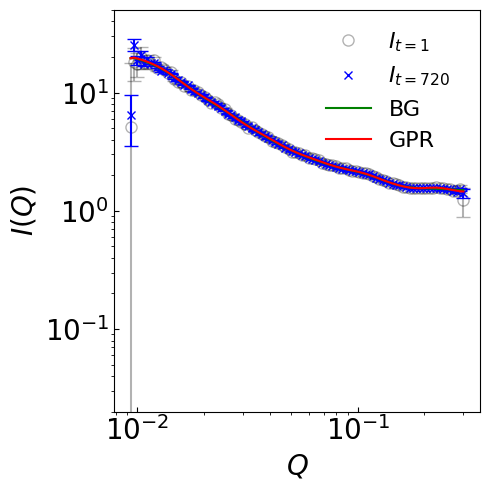

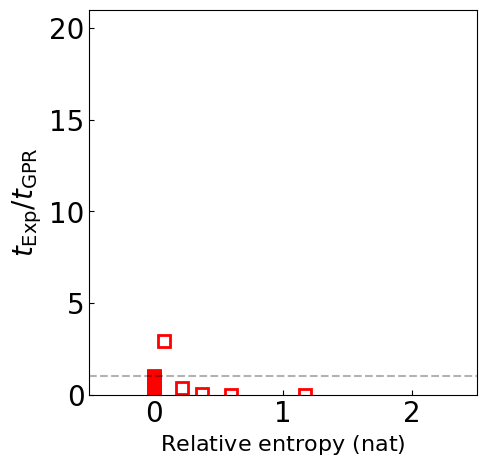

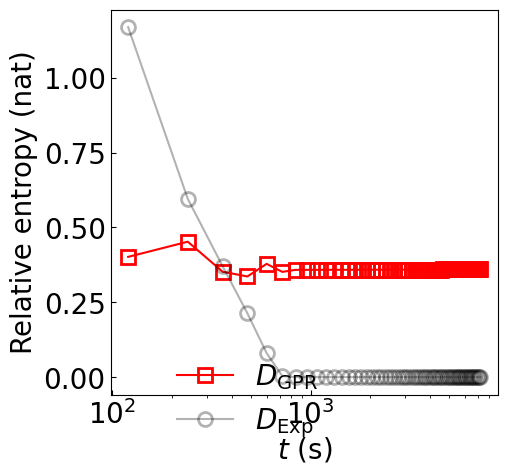

In [11]:
# plot the GPR result
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)

i_time_exp = 0
I_gp = list_I_mean_gp[i_time_exp]
I_gp_err = list_I_std_gp[i_time_exp]

data = data_list[i_time_exp]
q_data = data[:, 0]
I_exp = data[:, 1]
I_exp_err = data[:, 2]

ax.plot(q_data, I_exp, 'ok', markersize=8, fillstyle='none', label=r'$I_{t=1}$', alpha=0.3) 
ax.errorbar(q_data, I_exp, yerr=I_exp_err, fmt='none', ecolor='k', capsize=5, alpha=0.3)

ax.fill_between(q_s, I_gp - I_gp_err, I_gp + I_gp_err, color='r', alpha=0.3)



# ax.plot(q_data, I_data_med , 'sc', label=r'$I_{t=240}$', fillstyle='none')
# ax.errorbar(q_data, I_data_med, yerr=I_err_data_med, fmt='none', ecolor='c', capsize=5)

ax.plot(q_data, I_data_good , 'xb', label=r'$I_{t=720}$')
ax.errorbar(q_data, I_data_good, yerr=I_err_data_good, fmt='none', ecolor='b', capsize=5)

ax.plot(q_data, I_q_gf, '-g', label='BG')
ax.plot(q_s, I_gp, '-r', label='GPR')

ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)$', fontsize=20)

ax.tick_params(direction='in', labelsize=20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([0.02, 50])
# ax.set_ylim([0, 5])

ax.legend(frameon=False, fontsize=16, loc='lower center', bbox_to_anchor=(0.75, 0.6))
plt.tight_layout()

# plot the time required for the GPR and the experimental data to reach the same relative entropy
f_interp_gpr = interp1d(list_G_acc_gpr[-1]-list_G_acc_gpr, np.log(time_list), kind='linear', fill_value='extrapolate')

time_gpr = np.zeros_like(time_list)
for i in range(len(list_G_acc_exp)):
    H_exp_gt_i = list_G_acc_exp[-1]-list_G_acc_exp[i]
    time_gpr[i] = np.exp(f_interp_gpr(H_exp_gt_i))

fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)
ax.plot((list_G_acc_exp[-1]-list_G_acc_exp), time_list/time_gpr, 'sr', color='r', fillstyle='none', ms=8, markeredgewidth=2, label = r'$t_\mathrm{GPR}$')
ax.plot([-0.5, 3], [1, 1], '--k', color='k', alpha=0.3, label = r'$t_\mathrm{Exp}$')

ax.set_xticks([0,1,2])
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim([-0.5, 2.5])
ax.set_ylim([0, 21])
ax.tick_params(direction='in', labelsize=20)
# ax.tick_params(axis='x', direction='in', labelsize=18)
ax.set_xlabel(r'$\mathrm{Relative\ entropy} \ \mathrm{(nat)}}$', fontsize=16)
ax.set_ylabel(r'$t_\mathrm{Exp}/t_\mathrm{GPR}$', fontsize=20)
# ax.legend(frameon=False, fontsize=14, loc = 'upper left')

filename = 'dKL_exp_21217-4m4a-HS.dat'
np.savetxt(filename, np.c_[time_list, list_G_acc_gpr, list_G_acc_exp, list_G_m], header='time/counts D_GPR D_Exp D_Ref')

fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)
ax.plot(time_list, list_G_acc_exp[-1]-list_G_acc_gpr, '-s', color='r', label=r'$D_{\mathrm{GPR}}$', fillstyle='none', ms=10, markeredgewidth=2)
ax.plot(time_list, list_G_acc_exp[-1]-list_G_acc_exp, '-o', color='k', label=r'$D_{\mathrm{Exp}}$', alpha=0.3, fillstyle='none', ms=10, markeredgewidth=2)
# ax.plot(time_list, list_G_acc_exp[-1]-list_G_m, '-o', color='C2', label=r'$\left\langle D(p_{\mathrm{GT}}||p_{\mathrm{Ref}})\right\rangle_{Q}$')

ax.set_xticks(time_list)
ax.set_xscale('log')
# ax.set_xscale('log')
# ax.set_ylim([-1, 15])
ax.tick_params(direction='in', labelsize=20)
# ax.tick_params(axis='x', direction='in', labelsize=18)
ax.set_xlabel(r'$t \ (\mathrm{s})$', fontsize=20)
ax.set_ylabel(r'Relative entropy (nat)', fontsize=20)
ax.legend(frameon=False, fontsize=20, bbox_to_anchor=[0.6, 0.15, 0, 0])

### DS 8m8a

In [12]:
# Define the folder path
folder_path = './data/EQSANS/output_21217/'

# List all files in the folder
filenames = os.listdir(folder_path)

# Extract unique time values from filenames and sort them
time_values_from_filenames = np.unique([float(filename.split('_')[5]) for filename in filenames if filename.endswith('.dat') and '8m8a' in filename and 'DS' in filename])
time_list = np.sort(time_values_from_filenames)

data_list = []

for i_time, time in enumerate(time_list):
    filename = f'DS-100_10C_8m8a_time_0_{time:0.0f}_Iq.dat'
    data = np.loadtxt(folder_path+filename, skiprows=2)
    data_list.append(data)
    
    print(i_time, time_list[i_time])

0 120.0
1 240.0
2 360.0
3 480.0
4 600.0
5 720.0
6 840.0
7 960.0
8 1080.0
9 1200.0
10 1320.0
11 1440.0
12 1560.0
13 1680.0
14 1800.0
15 1920.0
16 2040.0
17 2160.0
18 2280.0
19 2400.0
20 2520.0
21 2640.0
22 2760.0
23 2880.0
24 3000.0
25 3120.0
26 3240.0
27 3360.0
28 3480.0
29 3600.0
30 3720.0
31 3840.0
32 3960.0
33 4080.0
34 4200.0
35 4320.0
36 4440.0
37 4560.0
38 4680.0
39 4800.0
40 4920.0
41 5040.0
42 5160.0
43 5280.0
44 5400.0
45 5520.0
46 5640.0
47 5760.0
48 5880.0
49 6000.0
50 6120.0
51 6240.0
52 6360.0
53 6480.0
54 6600.0
55 6720.0
56 6840.0
57 6960.0
58 7080.0
59 7200.0


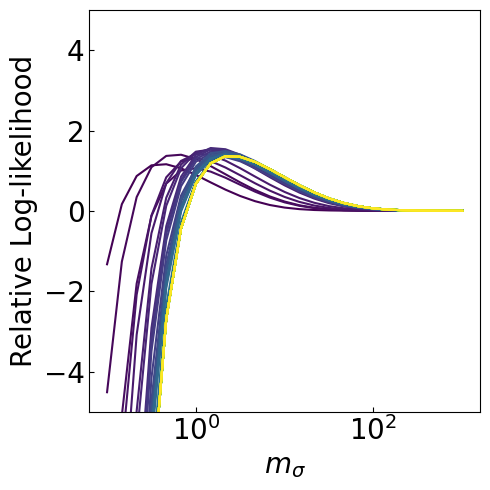

In [13]:
n_trial = 1
filter_size = 0.25
I_bg = 0.1
use_log_I = False
use_log_Q = True

# Transformations on Q and I(Q)
f_Q = lambda q: q
f_inv_Q = lambda fq: fq
if use_log_Q:
    f_Q = lambda q: np.log(q)
    f_inv_Q = lambda fq: np.exp(fq)


f_I = lambda I: I
f_inv_I = lambda fI: fI
# if use_log_I:
#     f_I = lambda I: np.log(I+I_bg)
#     f_inv_I = lambda fI: np.exp(fI)-I_bg
if use_log_I:
    f_I = lambda I: f_loglin(I, x_c=I_bg*2)
    f_inv_I = lambda fI: f_loglin_inv(fI, y_c=np.log(I_bg*2))

def get_viridis_color(value):
    cmap = plt.get_cmap('viridis')
    return cmap(value)

fig = plt.figure(figsize=(5, 5))

# n_sample_list = np.array([1000, 2000, 5000, 10000, 20000, 50000, 100000])
# n_sample_list = np.linspace(1000, 20000, 10)
n_sample_list = np.logspace(1, 7, 13)

list_L_gpr = []
list_L_exp = []
list_mse_gpr = []
list_mse_exp = []
list_G_acc_gpr = []
list_G_acc_exp = []
list_G_m = []

list_I_mean_gp = []
list_I_std_gp = []

for i_t, time in enumerate(time_list):
    
    ax = plt.subplot(1, 1, 1)

    color = get_viridis_color(i_t/(len(time_list)-1))


    log_likelihood_gt_exp = 0
    log_likelihood_gt_gpr = 0
    mse_exp = 0
    mse_gpr = 0
    G_acc_gpr = 0
    G_acc_exp = 0
    G_m = 0
    
    for i_trial in range(n_trial):
        # The noisy data
        index_data = i_t
        data = data_list[index_data]
        q_data = data[:, 0]
        I_data = data[:, 1]
        I_err_data = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
        # Scan through each data point, if find zero, assign that value as previous data
        for i in range(1, len(I_err_data)):
            if I_err_data[i] == 0:
                I_err_data[i] = I_err_data[i - 1]
                
        # The smooth data
        index_data_good = len(time_list)-1
        data = data_list[index_data_good]
        q_data_good = data[:, 0]
        I_data_good = data[:, 1]
        I_err_data_good = data[:, 2] #+ np.min(data[:, 2][data[:, 2] > 0])
        # Scan through each data point, if find zero, assign that value as previous data
        for i in range(1, len(I_err_data_good)):
            if I_err_data_good[i] == 0:
                I_err_data_good[i] = I_err_data_good[i - 1]
                
        index_outlier_sm = (q_data > 0.07)|(q_data < 0.0031)  
        index_outlier = (q_data < 0.07)&(q_data > 0.0031)
        
        I_q_gf = np.zeros_like(q_data)
        for i_iterate in range(5):
            I_q_gf_i = np.zeros_like(q_data)
            I_iterate = I_data - I_q_gf
            for i in range(len(q_data)):
                weight_list = np.exp(-((f_Q(q_data[i])-f_Q(q_data))/filter_size)**2/2)
                weight_list[index_outlier_sm] = 0
                weight_list = weight_list/np.sum(weight_list)
                I_q_gf_i[i] = np.sum(I_iterate*weight_list)
            n_sm = 1
            I_q_gf_i[n_sm:-n_sm] = desmear(f_Q(q_data), I_q_gf_i, I_q_gf_i*0+1, np.ones_like(I_q_gf)*filter_size, n=n_sm, sigmascale=1)
            I_q_gf = I_q_gf + I_q_gf_i

        ## GPR
        sigma_list = np.logspace(-1, 3, 25)
        log_likelihood_list = []
        for sigma in sigma_list:
            lmbda = 0.18
            # sigma = 10

            ## define kernel function
            y_data = f_I(I_data)
            y_gt = f_I(I_data_good)
            y_bg = f_I(I_q_gf)
            # y_bg = y_gt
            y = y_data-y_bg

            # y_err = np.sqrt(n_sample/np.sum(n_pixels_q)*1/np.maximum(sum_q,np.ones_like(q)))
            y_err_pixel = I_err_data
            y_err = y_err_pixel
            if use_log_I:
                y_err = y_err_pixel*f_loglin_deriv(I_data, x_c=I_bg*2)

            # scale by a factor to check whether error estimation is correct
            m_factor = 1
            y_bg = y_bg*m_factor
            y_gt = y_gt*m_factor
            y = y*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))*np.random.normal(size = y.shape)
            y_err = y_err*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))
            y_data = y_data*m_factor
            sig_var = np.mean(y[index_outlier]**2)
            
            # fluctuations of the prior distribution
            prior_sigma = np.sqrt(sig_var)
            # prior_sigma = np.sqrt(np.mean(y_err**2))
            # prior_sigma = np.sqrt(y_err**2+sig_var) 

            q_x = q_data
            q_s = q_data

            def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
                if std_1 is None:
                    std_1 = np.ones_like(q1)
                if std_2 is None:
                    std_2 = np.ones_like(q2)
                K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
                return K
            
            f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
            K_sigma = np.diag(f_y_err(y_err))
            # K_sigma = sigma**2*np.eye(len(q_x))
            K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma #+ 0*np.eye(len(q_x))
            K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
            k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

            L = np.linalg.cholesky(K_xx)
            alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
            v = np.linalg.solve(L, K_xs)
            mu_s = K_xs.T @ alpha
            cov_s = k_ss - v.T @ v
            var_s = np.diag(cov_s)*prior_sigma**2
            std_s = np.sqrt(var_s)

            # evaluate the log likelihood
            log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
            log_likelihood_list.append(log_likelihood)
            
        log_likelihood_list = np.array(log_likelihood_list)
        log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q_s)

        ax.plot(sigma_list, log_likelihood_list, '-', color=color)
        ax.set_xscale('log')
        ax.set_ylim([-5, 5])
        ax.tick_params(direction='in', labelsize=20)
        ax.set_xlabel(r'$m_\sigma$', fontsize=20)
        ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

        sigma_best = sigma_list[np.argmax(log_likelihood_list)]
        
        # ax.legend(frameon=False, fontsize=13, ncol=2)
        plt.tight_layout()

        # GPR with best sigma
        f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
        K_sigma = np.diag(f_y_err(y_err))
        # K_sigma = sigma**2*np.eye(len(q_x))
        K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma
        K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
        k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

        L = np.linalg.cholesky(K_xx)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        v = np.linalg.solve(L, K_xs)
        mu_s = K_xs.T @ alpha
        cov_s = k_ss - v.T @ v
        var_s = np.diag(cov_s)*prior_sigma**2
        std_s = np.sqrt(var_s)
        
        I_mean_GP = f_inv_I(mu_s + y_bg)
        I_std_GP = std_s
        if use_log_I:
            I_std_GP = std_s/f_loglin_deriv(I_data, x_c=I_bg*2)
            
        delta_gp_bg = np.sqrt((f_inv_I(y_gt)-f_inv_I(y_bg))**2)
        # sigma_gt = np.ones_like(y_gt)*(np.max(y_gt)-np.min(y_gt))*1e-3
        sigma_gt = prior_sigma
        
        # Calculate the in terms of cross entropy              
        importance = np.where((q_data > 0.07)|(q_data < 0.0031) , 0, 1)
        # importance = None
        
        h_m_gt = f_log_likelihood((y_bg), prior_sigma, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        h_gpr_gt = f_log_likelihood((mu_s + y_bg), std_s, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)
        h_exp_gt = f_log_likelihood((y_data), y_err, (y_gt), sigma_gt, z_list=np.linspace(-6, 6, 99), importance=importance, index=index_outlier)/len(q_data)

        
        G_acc_gpr += h_gpr_gt#-h_m_gt
        G_acc_exp += h_exp_gt#-h_m_gt
        G_m += h_m_gt
        
        # likelihood of gt within the experimental prediction
        # log_likelihood_gt_exp += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), f_inv_I(y_data), y_err_pixel)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_exp += f_log_likelihood((y_gt), sigma_gt, y_data, y_err_pixel)/len(q_data)#, z_list=np.linspace(-4, 4, 49))
        
        # likelihood of gt within the GPR prediction
        # log_likelihood_gt_gpr += f_log_likelihood(f_inv_I(y_gt), np.zeros_like(y_gt), I_mean_GP, I_std_GP)#, z_list=np.linspace(-4, 4, 49))
        log_likelihood_gt_gpr += f_log_likelihood((y_gt), sigma_gt, mu_s + y_bg, std_s)/len(q_data)#, z_list=np.linspace(-4, 4, 49))
        
        # mean squared error of gt and experimental prediction
        # mse_exp += f_mse(y + y_bg, y_gt)
        mse_exp += f_mse(f_inv_I(y_data),f_inv_I(y_gt))
        
        # mean squared error of gt and GPR prediction
        # mse_gpr += f_mse(mu_s + y_bg, y_gt)
        mse_gpr += f_mse(I_mean_GP, f_inv_I(y_gt))
        
    list_I_mean_gp.append(I_mean_GP)
    list_I_std_gp.append(I_std_GP)        
        
    list_L_exp.append(log_likelihood_gt_exp/n_trial)
    list_L_gpr.append(log_likelihood_gt_gpr/n_trial)
    list_mse_exp.append(mse_exp/n_trial)
    list_mse_gpr.append(mse_gpr/n_trial)
    list_G_acc_gpr.append(G_acc_gpr/n_trial)
    list_G_acc_exp.append(G_acc_exp/n_trial)
    list_G_m.append(G_m/n_trial)

# convert the lists to numpy arrays
list_L_exp = np.array(list_L_exp)
list_L_gpr = np.array(list_L_gpr)
list_mse_exp = np.array(list_mse_exp)
list_mse_gpr = np.array(list_mse_gpr)
list_G_acc_gpr = np.array(list_G_acc_gpr)
list_G_acc_exp = np.array(list_G_acc_exp)
list_G_m = np.array(list_G_m)

/tmp/ipykernel_3252117/353926758.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "sr" (-> color='r'). The keyword argument will take precedence.
  ax.plot((list_G_acc_exp[-1]-list_G_acc_exp), time_list/time_gpr, 'sr', color='r', fillstyle='none', ms=8, markeredgewidth=2, label = r'$t_\mathrm{GPR}$')
/tmp/ipykernel_3252117/353926758.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  ax.plot([-0.5, 3], [1, 1], '--k', color='k', alpha=0.3, label = r'$t_\mathrm{Exp}$')


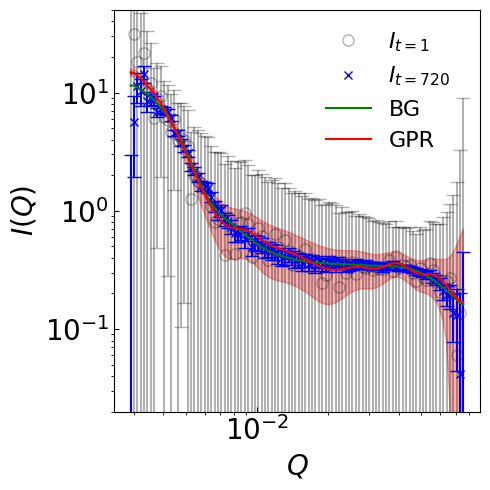

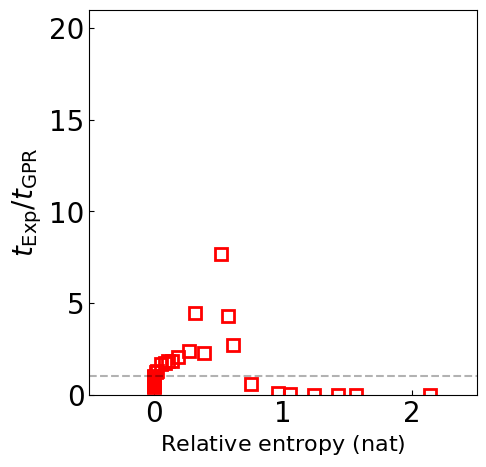

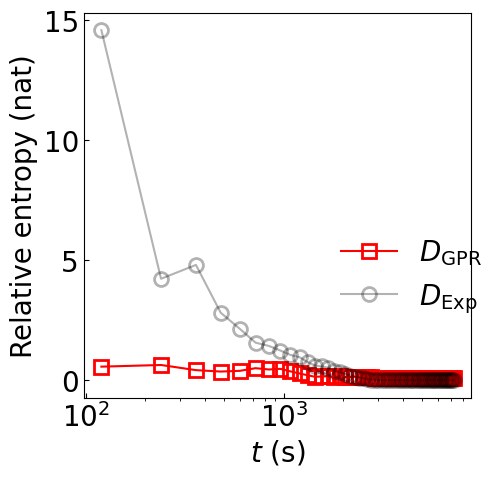

In [14]:
# plot the GPR result
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)

i_time_exp = 0
I_gp = list_I_mean_gp[i_time_exp]
I_gp_err = list_I_std_gp[i_time_exp]

data = data_list[i_time_exp]
q_data = data[:, 0]
I_exp = data[:, 1]
I_exp_err = data[:, 2]

ax.plot(q_data, I_exp, 'ok', markersize=8, fillstyle='none', label=r'$I_{t=1}$', alpha=0.3) 
ax.errorbar(q_data, I_exp, yerr=I_exp_err, fmt='none', ecolor='k', capsize=5, alpha=0.3)

ax.fill_between(q_s, I_gp - I_gp_err, I_gp + I_gp_err, color='r', alpha=0.3)

# ax.plot(q_data, I_data_med , 'sc', label=r'$I_{t=240}$', fillstyle='none')
# ax.errorbar(q_data, I_data_med, yerr=I_err_data_med, fmt='none', ecolor='c', capsize=5)

ax.plot(q_data, I_data_good , 'xb', label=r'$I_{t=720}$')
ax.errorbar(q_data, I_data_good, yerr=I_err_data_good, fmt='none', ecolor='b', capsize=5)

ax.plot(q_data, I_q_gf, '-g', label='BG')
ax.plot(q_s, I_gp, '-r', label='GPR')

ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)$', fontsize=20)

ax.tick_params(direction='in', labelsize=20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([0.02, 50])
# ax.set_ylim([0, 5])

ax.legend(frameon=False, fontsize=16, loc='lower center', bbox_to_anchor=(0.75, 0.6))
plt.tight_layout()

# plot the time required for the GPR and the experimental data to reach the same relative entropy
f_interp_gpr = interp1d(list_G_acc_gpr[-1]-list_G_acc_gpr, np.log(time_list), kind='linear', fill_value='extrapolate')

time_gpr = np.zeros_like(time_list)
for i in range(len(list_G_acc_exp)):
    H_exp_gt_i = list_G_acc_exp[-1]-list_G_acc_exp[i]
    time_gpr[i] = np.exp(f_interp_gpr(H_exp_gt_i))

fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)
ax.plot((list_G_acc_exp[-1]-list_G_acc_exp), time_list/time_gpr, 'sr', color='r', fillstyle='none', ms=8, markeredgewidth=2, label = r'$t_\mathrm{GPR}$')
ax.plot([-0.5, 3], [1, 1], '--k', color='k', alpha=0.3, label = r'$t_\mathrm{Exp}$')

ax.set_xticks([0,1,2])
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim([-0.5, 2.5])
ax.set_ylim([0, 21])
ax.tick_params(direction='in', labelsize=20)
# ax.tick_params(axis='x', direction='in', labelsize=18)
ax.set_xlabel(r'$\mathrm{Relative\ entropy} \ \mathrm{(nat)}}$', fontsize=16)
ax.set_ylabel(r'$t_\mathrm{Exp}/t_\mathrm{GPR}$', fontsize=20)
# ax.legend(frameon=False, fontsize=14, loc = 'upper left')

filename = 'dKL_exp_21217-8m8a-DS.dat'
np.savetxt(filename, np.c_[time_list, list_G_acc_gpr, list_G_acc_exp, list_G_m], header='time/counts D_GPR D_Exp D_Ref')

fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)
ax.plot(time_list, list_G_acc_exp[-1]-list_G_acc_gpr, '-s', color='r', label=r'$D_{\mathrm{GPR}}$', fillstyle='none', ms=10, markeredgewidth=2)
ax.plot(time_list, list_G_acc_exp[-1]-list_G_acc_exp, '-o', color='k', label=r'$D_{\mathrm{Exp}}$', alpha=0.3, fillstyle='none', ms=10, markeredgewidth=2)
# ax.plot(time_list, list_G_acc_exp[-1]-list_G_m, '-o', color='C2', label=r'$\left\langle D(p_{\mathrm{GT}}||p_{\mathrm{Ref}})\right\rangle_{Q}$')

ax.set_xticks(time_list)
ax.set_xscale('log')
# ax.set_xscale('log')
# ax.set_ylim([-1, 15])
ax.tick_params(direction='in', labelsize=20)
# ax.tick_params(axis='x', direction='in', labelsize=18)
ax.set_xlabel(r'$t \ (\mathrm{s})$', fontsize=20)
ax.set_ylabel(r'Relative entropy (nat)', fontsize=20)
ax.legend(frameon=False, fontsize=20, bbox_to_anchor=[0.6, 0.15, 0, 0])